# Ternary plots for vanilla classifiers

In [1]:
import os
import sys
import time
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from scipy import stats
from scipy.special import softmax
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense

from utils.ops import onehot_encode
from utils.data import get_cifar3
from utils.metrics import neg_log_likelihood, accuracy
from utils.visualization import plot_pdf_triplex, plot_prob_triplex

In [2]:
%matplotlib inline

## Load IRIS dataset

In [3]:
iris = load_iris()
ix2label = {
    0: 'Setosa',
    1: 'Versicolour',
    2: 'Virginica'}

There are 50 samples per class, we can take 15 of each to form a validation set. Samples come ordered by class, the first 50 are class-0 samples, etc..

In [4]:
n_samples_class = 30

idxs0, idxs1, idxs2 = np.random.permutation(50), np.random.permutation(50)+50, np.random.permutation(50)+100

X_train = np.vstack((iris.data[idxs0[:n_samples_class], :],
                     iris.data[idxs1[:n_samples_class], :],
                     iris.data[idxs2[:n_samples_class], :]))
y_train = np.hstack((iris.target[idxs0[:n_samples_class]], iris.target[idxs1[:n_samples_class]], iris.target[idxs2[:n_samples_class]]))

X_test = np.vstack((iris.data[idxs0[n_samples_class:], :],
                    iris.data[idxs1[n_samples_class:], :],
                    iris.data[idxs2[n_samples_class:], :]))
y_test = np.hstack((iris.target[idxs0[n_samples_class:]], iris.target[idxs1[n_samples_class:]], iris.target[idxs2[n_samples_class:]]))

### Train a SVM

In [5]:
svc = SVC(kernel='rbf', probability=True);
svc.fit(X_train, y_train);

C:\Users\sergi\Anaconda3\envs\famarch\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [6]:
# Performance
print("Accuracy: {:.3f}".format(svc.score(X_train, y_train)))
print("Accuracy on the test set: {:.3f}".format(svc.score(X_test, y_test)))

probs = svc.predict_proba(X_train)
probs_test = svc.predict_proba(X_test)
print("Cross-entropy: {:.3f}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {:.3f}".format(neg_log_likelihood(probs_test, y_test)))

Accuracy: 0.989
Accuracy on the test set: 0.967
Cross-entropy: 0.100
Cross-entropy on the test set: 0.113


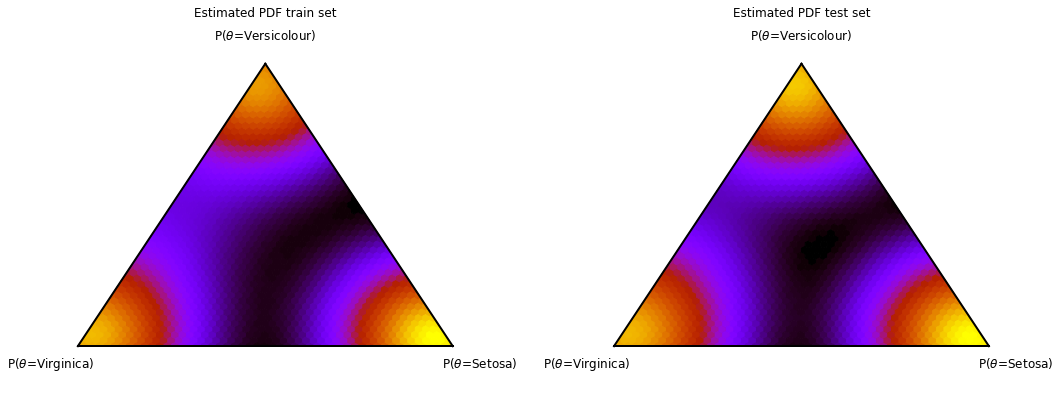

In [7]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(probs_test, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

### Temperature Scaling effects 

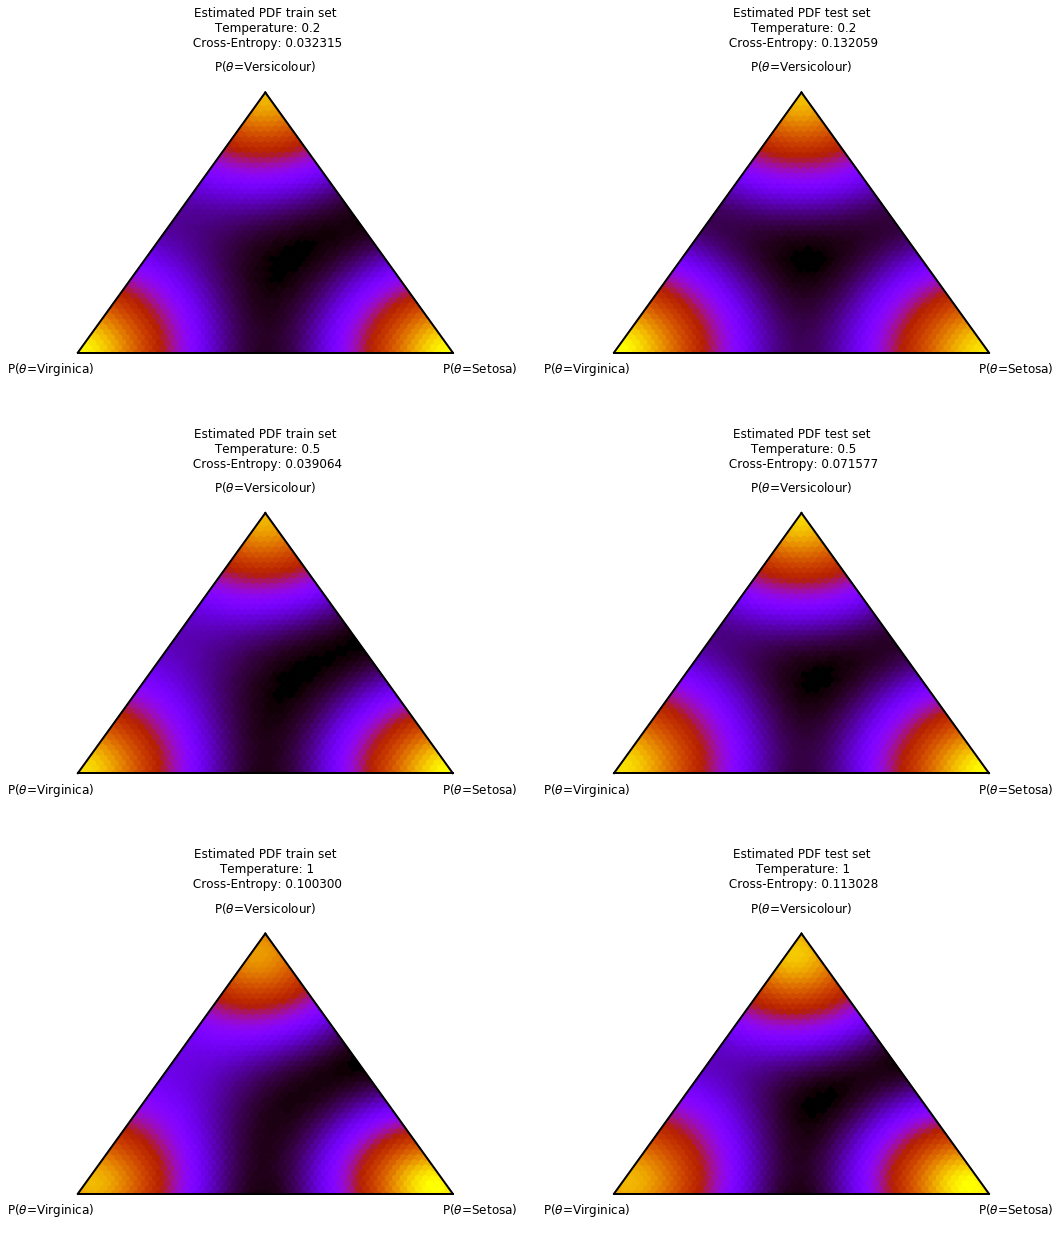

In [8]:
train_logits = svc.predict_log_proba(X_train)
test_logits = svc.predict_log_proba(X_test)

Ts = [0.2, 0.5, 1]
fig, ax_arr = plt.subplots(len(Ts), 2, figsize=(17, 7*len(Ts)), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

for i, T in enumerate(Ts):
    train_probs = softmax(train_logits/T, axis=1)
    test_probs = softmax(test_logits/T, axis=1)
    train_xentropy = neg_log_likelihood(train_probs, y_train)
    test_xentropy = neg_log_likelihood(test_probs, y_test)
    
    ax_arr[i, 0] = plot_pdf_triplex(train_probs, ax=ax_arr[i, 0],
                                 title='Estimated PDF train set\n Temperature: {}\n Cross-Entropy: {:3f}'.format(T, train_xentropy),
                                 fontsize=12, labels=list(ix2label.values()));
    ax_arr[i, 1] = plot_pdf_triplex(test_probs, ax=ax_arr[i, 1],
                                 title='Estimated PDF test set\n Temperature: {}\n Cross-Entropy: {:3f}'.format(T, test_xentropy),
                                 fontsize=12, labels=list(ix2label.values()));
plt.show()

### Optimum temperature

In [9]:
def optim_temperature(logits, target, min_diff=1e-5, step=0.1):
    T = 1.0
    probs = softmax(logits/T, axis=1)

    while True:
        # Compute gradient w.r.t. T
        one_hot = onehot_encode(target)
        grad = -np.mean(np.sum((probs-one_hot)*logits/T**2, axis=1))

        # Update step
        probs_new = softmax(logits/(T-grad*step), axis=1)

        if abs(grad*step) < min_diff:
            break

        T -= grad*step
        probs = probs_new

    return T

In [10]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 0.235
 achieves LNN=0.115 on test set
Optimum temperature for test set: 0.559
 achieves LNN=0.071 on test set


### Load CIFAR-3

In [11]:
data_path = '../cifar-10'
cifar3, ix2label = get_cifar3(data_path, target_labels=['airplane', 'automobile', 'bird'], test=True,
                              prior=[0.5, 0.2, 0.3], test_prior=[0.3, 0.5, 0.2])

### Train a simple classifier: PCA+Logistic

In [12]:
# Hyperparameters
n_components = 20

In [13]:
# Prepare data
y_train = cifar3['labels']
X_train = np.array([ima.flatten() for ima in cifar3['images']])

y_test = cifar3['test_labels']
X_test = np.array([ima.flatten() for ima in cifar3['test_images']])

In [14]:
# Fit PCA
pca = PCA(n_components=n_components, svd_solver='randomized',whiten=True).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [15]:
# Train LogisticRegression
t0 = time.time()
logistic = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(X_train_pca, y_train)
print("Fitted in {:.3f}s".format(time.time() - t0))

Fitted in 0.063s


In [16]:
# Train and test performance
print("Accuracy on the train set: {}".format(logistic.score(X_train_pca, y_train)))
print("Accuracy on the test set: {}".format(logistic.score(X_test_pca, y_test)))

probs = logistic.predict_proba(X_train_pca)
test_probs = logistic.predict_proba(X_test_pca)
print("Cross-entropy on the train set: {}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.7056
Accuracy on the test set: 0.6315
Cross-entropy on the train set: 0.7351795418917888
Cross-entropy on the test set: 0.8689235600985208


## Visualizing results 

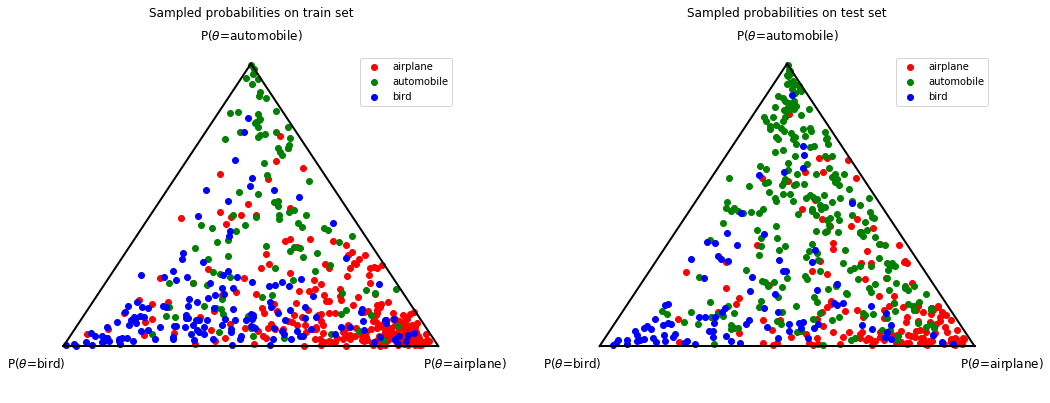

In [17]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_prob_triplex(probs[:500], target=y_train[:500], ax=ax_arr[0],
                              title='Sampled probabilities on train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_prob_triplex(test_probs[:500], target=y_test[:500], ax=ax_arr[1],
                              title='Sampled probabilities on test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

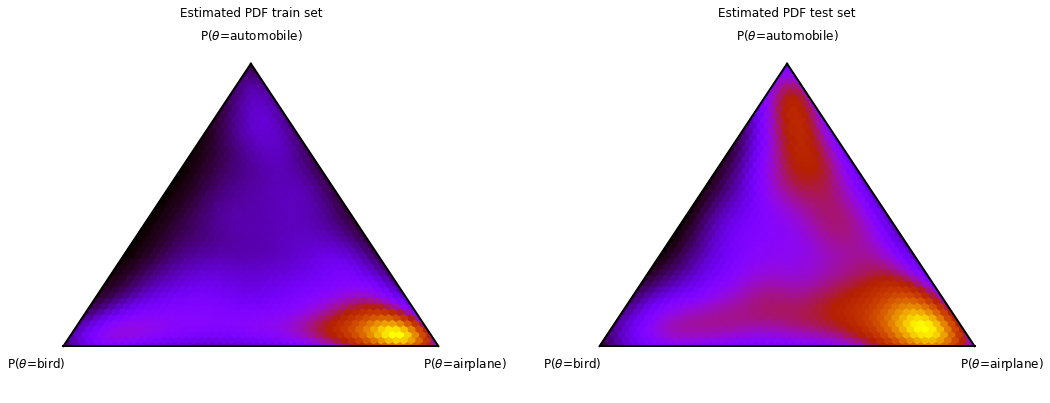

In [18]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

### Temperature Scaling effects

In [19]:
train_logits = logistic.predict_log_proba(X_train_pca)
test_logits = logistic.predict_log_proba(X_test_pca)

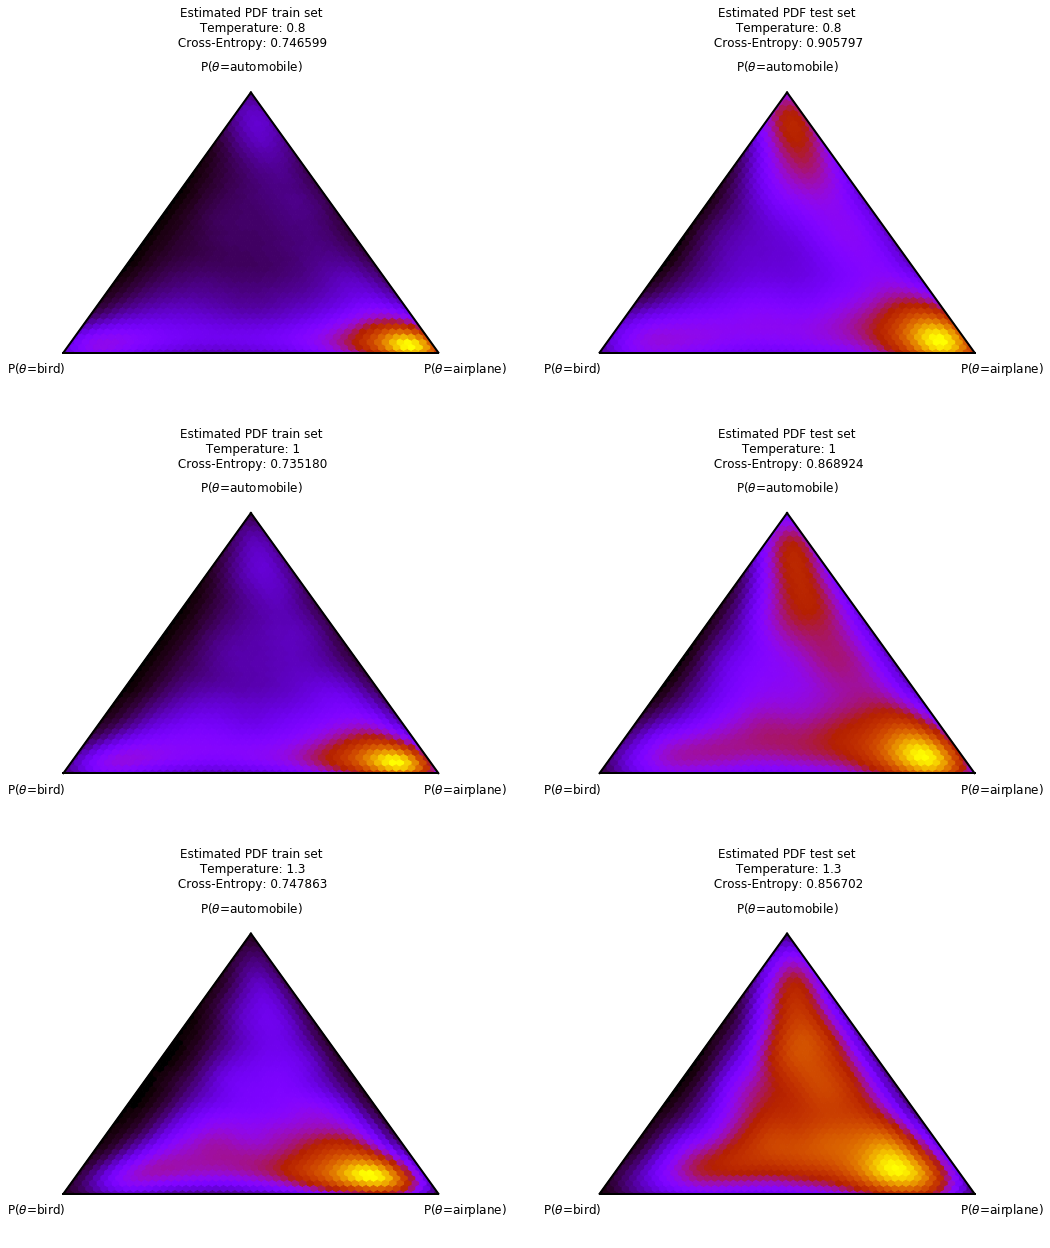

In [20]:
Ts = [0.8, 1, 1.3]
fig, ax_arr = plt.subplots(len(Ts), 2, figsize=(17, 7*len(Ts)), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

for i, T in enumerate(Ts):
    train_probs = softmax(train_logits/T, axis=1)
    test_probs = softmax(test_logits/T, axis=1)
    train_xentropy = neg_log_likelihood(train_probs, y_train)
    test_xentropy = neg_log_likelihood(test_probs, y_test)
    
    ax_arr[i, 0] = plot_pdf_triplex(train_probs, ax=ax_arr[i, 0],
                                 title='Estimated PDF train set\n Temperature: {}\n Cross-Entropy: {:3f}'.format(T, train_xentropy),
                                 fontsize=12, labels=list(ix2label.values()));
    ax_arr[i, 1] = plot_pdf_triplex(test_probs, ax=ax_arr[i, 1],
                                 title='Estimated PDF test set\n Temperature: {}\n Cross-Entropy: {:3f}'.format(T, test_xentropy),
                                 fontsize=12, labels=list(ix2label.values()));
plt.show()

In [21]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 1.000
 achieves LNN=0.869 on test set
Optimum temperature for test set: 1.286
 achieves LNN=0.857 on test set


## PCA + SVMLinear

In [22]:
# Train SVM
t0 = time.time()
svc = SVC(kernel='linear', probability=True);
svc.fit(X_train_pca, y_train);
print("Fitted in {:.3f}s".format(time.time() - t0))

Fitted in 37.139s


In [23]:
# Train and test performance
print("Accuracy on the train set: {}".format(svc.score(X_train_pca, y_train)))
print("Accuracy on the test set: {}".format(svc.score(X_test_pca, y_test)))

probs = svc.predict_proba(X_train_pca)
test_probs = svc.predict_proba(X_test_pca)
print("Cross-entropy on the train set: {}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.7096
Accuracy on the test set: 0.6275
Cross-entropy on the train set: 0.7355934627925395
Cross-entropy on the test set: 0.8712243178210437


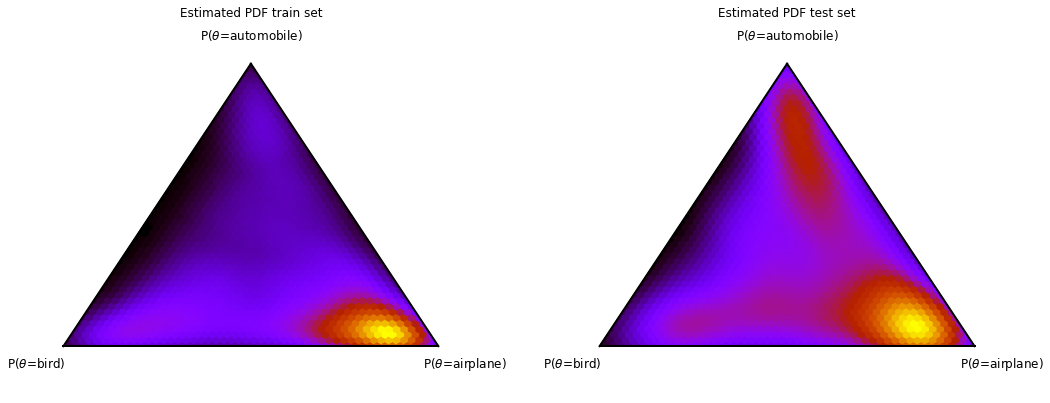

In [24]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

In [25]:
train_logits = svc.predict_log_proba(X_train_pca)
test_logits = svc.predict_log_proba(X_test_pca)

In [26]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 0.960
 achieves LNN=0.875 on test set
Optimum temperature for test set: 1.253
 achieves LNN=0.862 on test set


## PCA + SVMPolynomial

In [27]:
# Train SVM
t0 = time.time()
svc_poly = SVC(kernel='poly', degree=2, probability=True);
svc_poly.fit(X_train_pca, y_train);
print("Fitted in {:.3f}s".format(time.time() - t0))

C:\Users\sergi\Anaconda3\envs\famarch\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Fitted in 16.117s


In [28]:
# Train and test performance
print("Accuracy on the train set: {}".format(svc_poly.score(X_train_pca, y_train)))
print("Accuracy on the test set: {}".format(svc_poly.score(X_test_pca, y_test)))

probs = svc_poly.predict_proba(X_train_pca)
test_probs = svc_poly.predict_proba(X_test_pca)
print("Cross-entropy on the train set: {}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.7288
Accuracy on the test set: 0.62
Cross-entropy on the train set: 0.6652768445899484
Cross-entropy on the test set: 0.845494355676387


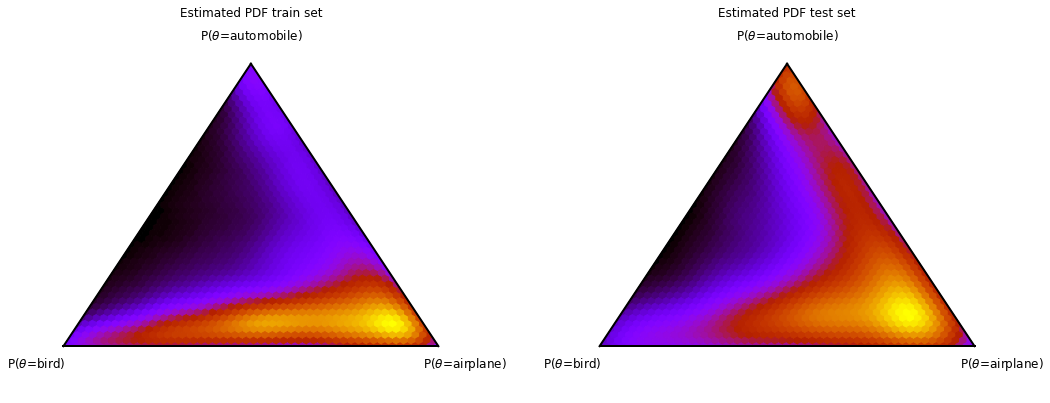

In [29]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

In [30]:
train_logits = svc_poly.predict_log_proba(X_train_pca)
test_logits = svc_poly.predict_log_proba(X_test_pca)

In [31]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 0.868
 achieves LNN=0.868 on test set
Optimum temperature for test set: 1.354
 achieves LNN=0.828 on test set


## PCA + SVMrbf 

In [32]:
# Train SVM
t0 = time.time()
svc_rbf = SVC(kernel='rbf', probability=True);
svc_rbf.fit(X_train_pca, y_train);
print("Fitted in {:.3f}s".format(time.time() - t0))

C:\Users\sergi\Anaconda3\envs\famarch\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Fitted in 18.000s


In [33]:
# Train and test performance
print("Accuracy on the train set: {}".format(svc_rbf.score(X_train_pca, y_train)))
print("Accuracy on the test set: {}".format(svc_rbf.score(X_test_pca, y_test)))

probs = svc_rbf.predict_proba(X_train_pca)
test_probs = svc_rbf.predict_proba(X_test_pca)
print("Cross-entropy on the train set: {}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.8559
Accuracy on the test set: 0.748
Cross-entropy on the train set: 0.3850696680087988
Cross-entropy on the test set: 0.581849990870497


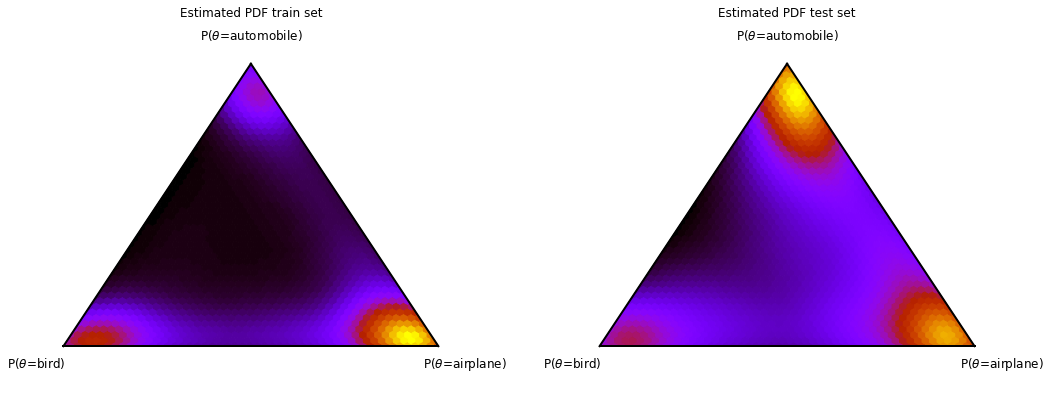

In [34]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

In [35]:
train_logits = svc_rbf.predict_log_proba(X_train_pca)
test_logits = svc_rbf.predict_log_proba(X_test_pca)

In [36]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 0.798
 achieves LNN=0.603 on test set
Optimum temperature for test set: 1.081
 achieves LNN=0.580 on test set


## Renset20

In [37]:
resnet_path = '../pretrained-models'

In [38]:
model = tf.keras.models.load_model(os.path.join(resnet_path, 'resnet20v1_cf3.h5'), custom_objects={'tf': tf})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [39]:
# Compute predictions
train_probs = model.predict(cifar3['images'])
test_probs = model.predict(cifar3['test_images'])

In [40]:
# Train and test performance
print("Accuracy on the train set: {}".format(accuracy(train_probs, y_train)))
print("Accuracy on the test set: {}".format(accuracy(test_probs, y_test)))


print("Cross-entropy on the train set: {}".format(neg_log_likelihood(train_probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.9515
Accuracy on the test set: 0.946
Cross-entropy on the train set: 0.1338972932720042
Cross-entropy on the test set: 0.15190914751146778


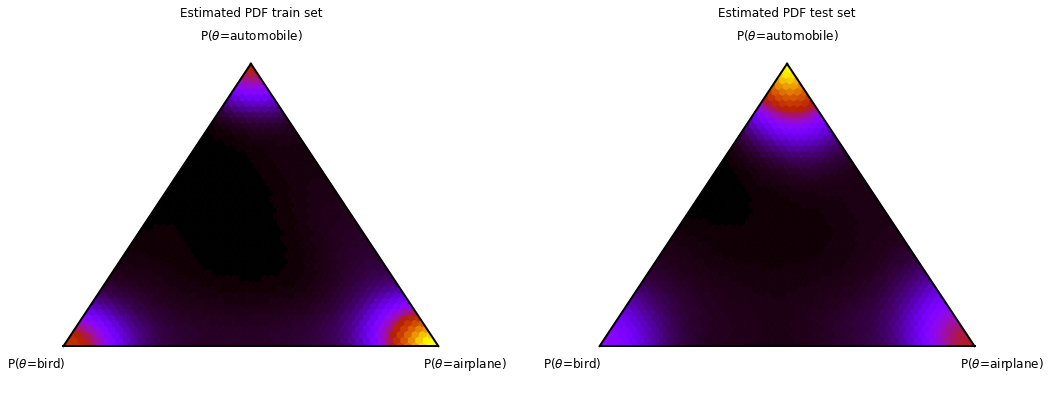

In [41]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(train_probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()